In [36]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt 

In [37]:
usuario = 'siempreread'
contrasena = 'S13mpr3_Ch1l3'
url_servidor = '209.151.148.250'
puerto = '3306'
esquema = 'EspoCRM2'
plugin_autenticacion = 'mysql_native_password'

# Conexión a la base de datos

c_conexion = 'mysql+mysqlconnector://{0}:{1}@{2}:{3}/{4}?auth_plugin={5}'
c_conexion = c_conexion.format(usuario, contrasena, url_servidor, puerto,
                               esquema, plugin_autenticacion)
motor_mysql_mariadb = create_engine(c_conexion)


#archivo de salida modificar segun archivo
archivo = 'C:/Users/jmartinez/Desktop/casos nuevos/clientes/1/casos_faltantes_segun_archivo.xlsx'

In [38]:
#ojo modificar año de la tabla  para ver bien los datos

sql = 'select *, month(created_at) as mes, year(created_at) as ano from contact where CHAR_LENGTH(rut_asegurado) > 6 AND CHAR_LENGTH(rut) > 6 and year(created_at) = 2022 and month(created_at)=5'
#dataframe desde consulta SQL ######   and month(created_at) = 6
datos = pd.read_sql_query(sql, motor_mysql_mariadb)


datos.shape


(45776, 65)

In [39]:
#tabla de emails
listado_email = 'SELECT t1.id,t3.lower as email FROM contact t1 left JOIN entity_email_address t2 ON t1.id = t2.entity_id left JOIN email_address t3 ON t2.email_address_id = t3.id '
emails = pd.read_sql_query(listado_email, motor_mysql_mariadb)
emails.shape

(1872597, 2)

In [40]:

#tabla excel con ruts faltantes
ruts_faltantes = 'C:/Users/jmartinez/Desktop/casos nuevos/casosfaltantes.xlsx'
listado_faltantes = pd.read_excel(ruts_faltantes)
listado_faltantes.shape

(191687, 3)

In [41]:
data20 = pd.merge(left=datos,right=emails, how='left', left_on='id', right_on='id',copy=False)
data20 = datos
data20.shape

(45776, 65)

In [42]:
data20.drop(['do_not_call','address_postal_code','marca_preexistencia','marca_programa_cronico','marca_enfermedad_alto_costo','marca_problemas_nutricionales','marca_trastornos_mentales','marca_momento_traumatico'], axis=1, inplace=True)
data20.drop(['url_empleador','marca_inicio_sintomas','marca_requirio_derivacion_emergencias','marca_requirio_internacion','marca_fecha_alta_seguimiento_virtual','middle_name'], axis=1, inplace=True)
data20.drop(['account_id','campaign_id','patologies','family_background','drug_history','hospital_and_surgeries_history','allergies','habits','habits_tobacco','habits_alcohol'],axis=1, inplace=True)
data20.drop(['habits_drugs','md_sedentarism','md_injuries_history','malnutrition','md_mental_illness','md_malnutrition','mes','ano'],axis=1, inplace=True)

#saca los espacios de todo el dataframe 
data20 = data20.replace(r"^ +| +$",r"",regex=True)

#cambia los valores en SEX
remplazahombremujer = {'Femenino': 'F', 'Masculino': 'M', '': 'O','Hombre':'M','Mujer':'F','M':'M','F':'F','O':'O','Ambos':'O','N':'O','Otro':'O','FEMENINO':'F','MASCULINO':'M'}
data20.replace({'sex': remplazahombremujer}, inplace=True)

#cambia los valores de relacion con titulares
relacion = {'Femenido':'F','masculino':'M','ND':'O','ES':'CO','Titular':'AS','Cónyuge':'CO','Hijo/a':'HI','Otro':'O','Mamá':'M','Papá':'P','Nieto/a':'NI','TITULAR':'AS','CÓNYUGE':'CO','HIJO':'HI','HIJA':'HI','OTRO':'O','PAPA':'P','MAMA':'M','PAPÁ':'P','MAMÁ':'M','NIETO':'NI','NIETA':'NI','PADRE':'P','MADRE':'M','COTIZANTE':'AS','CONYUGE':'CO','Mama':'M','Pareja':'CO','CONYUGE/CONVIVIENTE':'CO','MA':'M','OT':'O','PA':'P','SO':'O'}
data20.replace({'relacion_con_asegurado': relacion}, inplace=True)

#saca acentos
acentos = {'Á':'A','É':'E','Í':'I','Ó':'O','Ú':'U','á':'a','é':'e','í':'i','ó':'o','ú':'u'}
data20.replace({'address_city': acentos}, inplace=True)
data20.replace({'address_state': acentos}, inplace=True)
data20.replace({'address_country': acentos}, inplace=True)

data20['relacion_con_asegurado'] = data20['relacion_con_asegurado'].str.upper()
data20['first_name'] = data20['first_name'].str.title()
data20['last_name'] = data20['last_name'].str.title()
data20['description'] = data20['description'].str.lower()
data20['address_street'] = data20['address_street'].str.title()
data20['address_city'] = data20['address_city'].str.title()
data20['address_state'] = data20['address_state'].str.title()
data20['address_country'] = data20['address_country'].str.title()
data20['campana_paciente'] = data20['campana_paciente'].str.upper()
data20['empleador'] = data20['empleador'].str.title()
data20['convenio'] = data20['convenio'].str.title()
data20['isapre'] = data20['isapre'].str.title()
data20['cargo'] = data20['cargo'].str.title()
data20['marca_estado_c19'] = data20['marca_estado_c19'].str.title()
data20['holding'] = data20['holding'].str.title()
data20['horariopreferente'].str.upper()
data20['division'] = data20['division'].str.title()
data20['ubicacion'] = data20['ubicacion'].str.title()
#data20['email'] = data20['email'].str.lower()


data20['address_city'] = data20['address_city'].str.strip('1234567890.#/}{)(¥|xX;,-_')
data20['address_state'] = data20['address_state'].str.strip('1234567890.#/}{)(¥|xX;,-_')
data20['address_street'] = data20['address_street'].str.strip(',.#/}{)(¥|xX;')
data20['address_country'] = data20['address_country'].str.strip('1234567890,.#/}{)(¥|xX;')

#sacar los puntos de los rut
data20['rut'] = data20['rut'].str.replace('.','')
data20['rut_asegurado'] = data20['rut_asegurado'].str.replace('.','')

data20['address_city'] =data20['address_city'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
data20['address_state'] =data20['address_state'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
data20['address_country'] =data20['address_country'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
#data20['address_city'] = data20['address_city'].str.rstrip('Region Metropolitana','Bahia','Sao Paulo','Buenos Aires','Capital Federal','Atlantico','Cordoba','Santa Fe','Rio Grande Do Sul','Rio De Janeiro','Santiago')
#data20['address_city'] = data20['address_city'].str.strip('1234567890.#/}{)(¥|xX;,-_')

data20['address_city'] = data20['address_city'].str.replace(', Region Metropolitana','')
data20['address_city'] = data20['address_city'].str.replace(', Bahia','')
data20['address_city'] = data20['address_city'].str.replace(', Sao Paulo','')
data20['address_city'] = data20['address_city'].str.replace(', Buenos Aires','')
data20['address_city'] = data20['address_city'].str.replace(', Capital Federal','')
data20['address_city'] = data20['address_city'].str.replace(', Atlantico','')
data20['address_city'] = data20['address_city'].str.replace(', Cordoba','')
data20['address_city'] = data20['address_city'].str.replace(', Santa Fe','')
data20['address_city'] = data20['address_city'].str.replace(', Rio Grande Do Sul','')
data20['address_city'] = data20['address_city'].str.replace(', Rio De Janeiro','')
data20['address_city'] = data20['address_city'].str.replace(', Santiago','')
data20['address_city'] = data20['address_city'].str.replace(', Santiago Metropolitan','')
data20['address_city'] = data20['address_city'].str.replace(', Santiago Metropolitana','')
data20['address_city'] = data20['address_city'].str.replace(', Morelos','')
data20['address_city'] = data20['address_city'].str.replace(', Concepcion','')
data20['address_city'] = data20['address_city'].str.replace(', San Jose','')
data20['address_city'] = data20['address_city'].str.replace(', San Pedro','')
data20['address_city'] = data20['address_city'].str.replace(', San Luis','')
data20['address_city'] = data20['address_city'].str.replace(', San Juan','')
data20['address_city'] = data20['address_city'].str.replace(', San Miguel','')
data20['address_city'] = data20['address_city'].str.replace(', San Martin','')
data20['address_city'] = data20['address_city'].str.replace(', San Salvador','')
data20['address_city'] = data20['address_city'].str.replace(', San Francisco','')
data20['address_city'] = data20['address_city'].str.replace(', San Bernardo','')
data20['address_city'] = data20['address_city'].str.replace(', San Carlos','')
data20['address_city'] = data20['address_city'].str.replace(', San Cristobal','')
data20['address_city'] = data20['address_city'].str.replace(', San Fernando','')
data20['address_city'] = data20['address_city'].str.replace(', Paraiba','')
data20['address_city'] = data20['address_city'].str.replace(', San Luis Potosi','')
data20['address_city'] = data20['address_city'].str.replace(', Concepcion','')
data20['address_city'] = data20['address_city'].str.replace(', Temuco','')
data20['address_city'] = data20['address_city'].str.replace('-Prov. De Bs.As.','')
data20['address_city'] = data20['address_city'].str.replace(' - Comuna 13','')
data20['address_city'] = data20['address_city'].str.replace(' - Buenos Aires','')
data20['address_city'] = data20['address_city'].str.replace(', Mendoza','')
data20['address_city'] = data20['address_city'].str.replace(', La Rioja','')
data20['address_city'] = data20['address_city'].str.replace(', Rio Negro','')
data20['address_city'] = data20['address_city'].str.replace(', Neuquen','')
data20['address_city'] = data20['address_city'].str.replace(', Tucuman','')
data20['address_city'] = data20['address_city'].str.replace(', Mexico State','')
data20['address_city'] = data20['address_city'].str.replace(', Distrito Federal','')
data20['address_city'] = data20['address_city'].str.replace(', Santa Catarina','')
data20['address_city'] = data20['address_city'].str.replace(', Santa Cruz','')
data20['address_city'] = data20['address_city'].str.replace(', Santa Fe','')
data20['address_city'] = data20['address_city'].str.replace(', Santa Elena','')
data20['address_city'] = data20['address_city'].str.replace(' - Capital Federal','')
data20['address_city'] = data20['address_city'].str.replace(' - Buenos Aires','')
data20['address_city'] = data20['address_city'].str.replace(' - Cordoba','')
data20['address_city'] = data20['address_city'].str.replace(' - Santa Fe','')
data20['address_city'] = data20['address_city'].str.replace(' - Rio Grande Do Sul','')
data20['address_city'] = data20['address_city'].str.replace(' - Rio De Janeiro','')
data20['address_city'] = data20['address_city'].str.replace(' - Santiago','')
data20['address_city'] = data20['address_city'].str.replace(', Entre Rios','')
data20['address_city'] = data20['address_city'].str.replace(', Chubut','')
data20['address_city'] = data20['address_city'].str.replace(', Chaco','')
data20['address_city'] = data20['address_city'].str.replace(', Catamarca','')
data20['address_city'] = data20['address_city'].str.replace(', Corrientes','')
data20['address_city'] = data20['address_city'].str.replace(', Tierra Del Fuego','')
data20['address_city'] = data20['address_city'].str.replace(', Entre Rios','')
data20['address_city'] = data20['address_city'].str.replace(', La Pampa','')
data20['address_city'] = data20['address_city'].str.replace(' - Isidro Casanova','')
data20['address_city'] = data20['address_city'].str.replace(' - San Miguel','')
data20['address_city'] = data20['address_city'].str.replace(' Area, Colombia','')
data20['address_city'] = data20['address_city'].str.replace(', Monte Grande','')
data20['address_city'] = data20['address_city'].str.replace(', Cundinamarca','')
data20['address_city'] = data20['address_city'].str.replace(', Canelones','')
data20['address_city'] = data20['address_city'].str.replace(', Bogota D.C','')
data20['address_city'] = data20['address_city'].str.replace(', La Plata','')
data20['address_city'] = data20['address_city'].str.replace(', Capital','') 
data20['address_city'] = data20['address_city'].str.replace(' Buenos Aires','')
data20['address_city'] = data20['address_city'].str.replace(', Valparaiso','')
data20['address_city'] = data20['address_city'].str.replace(', Chiapas','')
data20['address_city'] = data20['address_city'].str.replace(', Veracruz','')
data20['address_city'] = data20['address_city'].str.replace(', Minas Gerais','')
data20['address_city'] = data20['address_city'].str.replace(', Espirito Santo','')
data20['address_city'] = data20['address_city'].str.replace(', Mato Grosso Do Sul','')
data20['address_city'] = data20['address_city'].str.replace(', Mato Grosso','')
data20['address_city'] = data20['address_city'].str.replace(', Minas Gerais','')
data20['address_city'] = data20['address_city'].str.replace(', Hidalgo','')
data20['address_city'] = data20['address_city'].str.replace(' - Monte Grande','')
data20['address_city'] = data20['address_city'].str.replace(', Pernambuco','')
data20['address_city'] = data20['address_city'].str.replace(', Dependencias Federales','')
data20['address_city'] = data20['address_city'].str.replace(', Tigre','')
data20['address_city'] = data20['address_city'].str.replace(', Lanus','')
data20['address_city'] = data20['address_city'].str.replace(', San Luis','')
data20['address_city'] = data20['address_city'].str.replace(' , Solano','')
data20['address_city'] = data20['address_city'].str.replace(' / Juana Koslay','')  
data20['address_city'] = data20['address_city'].str.replace(' - Vicente Lopez','')
data20['address_city'] = data20['address_city'].str.replace(' - San Isidro','')
data20['address_city'] = data20['address_city'].str.replace(' - Mendoza','')
data20['address_city'] = data20['address_city'].str.replace(', Vicente Lopez','')
data20['address_city'] = data20['address_city'].str.replace(' - Vicente Lopez','')
data20['address_city'] = data20['address_city'].str.replace(', Vicente Lopez','')
data20['address_city'] = data20['address_city'].str.replace(', San Isidro','')
data20['address_city'] = data20['address_city'].str.replace('. Cordoba','')
data20['address_city'] = data20['address_city'].str.replace(' - Avellaneda','')
data20['address_city'] = data20['address_city'].str.replace(' ( La Matanza )','')
data20['address_city'] = data20['address_city'].str.replace(' - La Tablada','')
data20['address_city'] = data20['address_city'].str.replace(', Vicente Lopez','')
data20['address_city'] = data20['address_city'].str.replace(' - Gregorio De Laferrere','')
data20['address_city'] = data20['address_city'].str.replace(', Metropolitana De Santiago','')
data20['address_city'] = data20['address_city'].str.replace(', Sinaloa','')
data20['address_city'] = data20['address_city'].str.replace(', Nuevo Leon','')
data20['address_city'] = data20['address_city'].str.replace(', Campeche','')
data20['address_city'] = data20['address_city'].str.replace(', Jalisco','')
data20['address_city'] = data20['address_city'].str.replace(', Tamaulipas','')
data20['address_city'] = data20['address_city'].str.replace(', Yucatan','')
data20['address_city'] = data20['address_city'].str.replace(', Quintana Roo','')
data20['address_city'] = data20['address_city'].str.replace(', Sonora','')
data20['address_city'] = data20['address_city'].str.replace(', Queretaro','')
data20['address_city'] = data20['address_city'].str.replace(', Sonora','')
data20['address_city'] = data20['address_city'].str.replace(', Goias','')
data20['address_city'] = data20['address_city'].str.replace(', Parana','')
data20['address_city'] = data20['address_city'].str.replace(', Amazonas','')
data20['address_city'] = data20['address_city'].str.replace(', Uruguay','')
data20['address_city'] = data20['address_city'].str.replace(', Miranda','')
data20['address_city'] = data20['address_city'].str.replace(', Caracas','')
data20['address_city'] = data20['address_city'].str.replace(', Sucre','')
data20['address_city'] = data20['address_city'].str.replace(', Antioquia','')
data20['address_city'] = data20['address_city'].str.replace(' - Maschwitz','')
data20['address_city'] = data20['address_city'].str.replace('- Temperley','')
data20['address_city'] = data20['address_city'].str.replace(' (Parque Avellaneda)','')
data20['address_city'] = data20['address_city'].str.replace(', Coahuila','')
data20['address_city'] = data20['address_city'].str.replace(', Baja California','')
data20['address_city'] = data20['address_city'].str.replace(', Alagoas','')
data20['address_city'] = data20['address_city'].str.replace(' - Sp','')
data20['address_city'] = data20['address_city'].str.replace(' - 13 - Region Metropolitana De Santiago - Chile','')
data20['address_city'] = data20['address_city'].str.replace(', Octava Region','')
data20['address_city'] = data20['address_city'].str.replace(' - 08 - Region Del Biobio - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' - 15 - Arica Y Parinacota - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' - 05 - Valparaiso - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' - 03 - Atacama - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' - 10 - Region De Los Lagos - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' - 02 - Antofagasta - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' - 01 - Tarapaca - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' - 07 - Region Del Maule - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' - 16 - Region De Nuble - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' - 14 - Region De Los Rios - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' - 04 - Coquimbo - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' - 06 - Region Del Libertador General Bernardo O\'higgins - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' - 03 - Atacama - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' - 09 - Region De Aysen Del General Carlos Ibanez Del Campo - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' - 12 - Region De Magallanes Y De La Antartica Chilena - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' - 15 - Arica Y Parinacota - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' - 07 - Region Del Maule - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' - 11 - Region Aisen Del Gral. Carlos Ibanez Del Camp - Chile','')
data20['address_city'] = data20['address_city'].str.replace(' 6 Ta Region','')
data20['address_city'] = data20['address_city'].str.replace(', Aysen','')



ciudades = {
'[No Especificado]':'',
'Region Metropolitana':'Santiago',
'No Informado':'',
'Metropolitana':'Santiago',
', Bahia':'',', Sao Paulo':'',
'Nuble':'Ñuble',
', Buenos Aires':'',
'Capital Federal':'Buenos Aires',
'Atlantico':'',
', Cordoba':'',
', Santa Fe':'',
', Rio Grande Do Sul':'',
', Rio De Janeiro':'',
', Santiago':'',
', Cordoba':'',
', Morelos':'',
', Paraiba':'',
', Santa Catarina':'',
'- Alto Macul':'',
'Metropolitana De Santiago':'Santiago',
', Temuco':'',
', Concepcion':'',
'Vina Del Mar':'Viña Del Mar',
'Nunoa':'Ñuñoa',
'Stgo':'Santiago',
'Santiago Centro':'Santiago',
'Vicuna':'Vicuña',
'Region De La Araucania':'Araucanía',
'Provincia Cordillera':'Cordillera',
'Provincia De Copiapo':'Copiapó',
'Buenos Aires Capital':'Buenos Aires',
'S\C':''
}
data20.replace({'address_city': ciudades}, inplace=True)
data20.replace({'address_state': ciudades}, inplace=True)
data20.replace({'address_country': ciudades}, inplace=True)

#saca los espacios de todo el dataframe
data20 = data20.replace(r"^ +| +$",r"",regex=True)
#data20['contar'] = data20['LLave'].str.contains(data20['LLave']).value_counts()[True]
data20['LLave'] = data20['rut'].astype(str) + data20['rut_asegurado'].astype(str) + data20['campana_paciente'].astype(str) + data20['empleador'].astype(str)


C:\Users\jmartinez\AppData\Local\Temp\ipykernel_19932\1759998169.py:50: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data20['rut'] = data20['rut'].str.replace('.','')
C:\Users\jmartinez\AppData\Local\Temp\ipykernel_19932\1759998169.py:51: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data20['rut_asegurado'] = data20['rut_asegurado'].str.replace('.','')
C:\Users\jmartinez\AppData\Local\Temp\ipykernel_19932\1759998169.py:90: FutureWarning: The default value of regex will change from True to False in a future version.
  data20['address_city'] = data20['address_city'].str.replace('-Prov. De Bs.As.','')
C:\Users\jmartinez\AppData\Local\Temp\ipykernel_19932\1759998169.py:125: Futu

In [43]:
data30 = pd.merge(left=listado_faltantes,right=data20,how='left',left_on='contact_id',right_on='id')
data30.shape

(191687, 37)

In [44]:
def cambiarSa(x):      
    #subcadena = 'Sa' #la subcadena que queremos
    #if subcadena in x and x.index(subcadena) != 0:
    
    if x[len(x)-2:] == 'Sa':
        x = x.replace('Sa','S.A.')
    if x[len(x)-2:] == 'S.':
        x = x.replace('S.','S.A.')
    if x[len(x)-3:] == 'S A':
        x = x.replace('S A','S.A.')
    if x[len(x)-3:] == 'SA.':
        x = x.replace('SA.','S.A.')
    if x[len(x)-3:] == 'S.A':
        x = x.replace('S.A','S.A.') 
    if x[len(x)-4:] == 'S. A': 
        x = x.replace('S. A','S.A.') 
    return x

def cambiarIn(y):
    
    if y[0:4] == 'Soc ':
        y = y.replace('Soc ','Soc. ')
    if y[0:5] == 'Serv ':
        y = y.replace('Serv ','Serv. ')
    if y[0:5] == 'Asoc ':
        y = y.replace('Asoc ','Asoc. ')
    return y

In [45]:
#ingresar data30 segun campaña
data30.empleador.fillna(data30.campana_paciente + ' empresa', inplace=True)
data30.holding.fillna('Holding ' + data30.campana_paciente, inplace=True)

data30.empleador = data30['empleador'].astype(str)

#saca acentos

#saca espacios

data30['empleador'] = data30['empleador'].str.strip()
data30['empleador'] = data30['empleador'].str.strip('.')

#los deja en mayuscula
data30['empleador'] = data30['empleador'].str.upper()
#los deja con la primera letra con mayuscula y el resto minuscula en todas las palabras
#data30['empleador'] = data30['empleador'].str.replace('S A','S.A.')
#data30['empleador'] = data30['empleador'].str.replace('SA.','S.A.')
#data30['empleador'] = data30['empleador'].str.replace('S.A','S.A.')
data30['empleador'] = data30['empleador'].str.replace('LTDA','Ltda.')
data30['empleador'] = data30['empleador'].str.replace('SAEZA.','SAESA.')
#data30['empleador'] = data30['empleador'].str.replace('s.A.','sa')

data30['empleador'] = data30['empleador'].str.replace('Á','A')
data30['empleador'] = data30['empleador'].str.replace('É','E')
data30['empleador'] = data30['empleador'].str.replace('Í','I')
data30['empleador'] = data30['empleador'].str.replace('Ó','O')
data30['empleador'] = data30['empleador'].str.replace('Ú','U')


data30['empleador'] = data30['empleador'].str.title()
data30['empleador'] = data30['empleador'].str.replace('Spa','Spa.')
data30['empleador'] = data30['empleador'].str.replace('Ltda..','Ltda.')
data30['empleador'] = data30['empleador'].str.replace('Limitada','Ltda.')
data30['empleador'] = data30['empleador'].str.replace('Siempre Chile','Care Assistance')
data30['empleador'] = data30['empleador'].str.replace('Colaboradores Empresas','Care Assistance')
data30['empleador'] = data30['empleador'].str.replace('Clalemana','Clinica Alemana')
data30['empleador'] = data30['empleador'].str.replace('Bancodechile','Banco de Chile')
data30['empleador'] = data30['empleador'].str.replace('Bancochile','Banco de Chile')
data30['empleador'] = data30['empleador'].str.replace('Conchaytoro','Concha y Toro')
data30['empleador'] = data30['empleador'].str.replace('Prueba Empresas','Testing De Ejecutivos')
data30['empleador'] = data30['empleador'].str.replace('Serv_Vicio','Servicio')
data30['empleador'] = data30['empleador'].str.replace('Socidad','Sociedad')
data30['empleador'] = data30['empleador'].str.replace('Serv.Bienestar','Serv. Bienestar')
data30['empleador'] = data30['empleador'].str.replace('S.P.A','Spa.')
data30['empleador'] = data30['empleador'].str.replace('10 Uf Asegurados En Evaluacion','Asegurados En Evaluacion')

data30['empleador'] = data30['empleador'].str.replace('Lmtda','Ltda.')

data30['empleador'] = data30['empleador'].apply(lambda x: cambiarSa(x))
data30['empleador'] = data30['empleador'].apply(lambda y: cambiarIn(y))

data30['holding'] = data30['holding'].str.strip('0123456789-_.,')
data30['holding'] = data30['holding'].str.strip()
data30['holding'] = data30['holding'].str.strip('.')

data30.convenio.fillna(data30.campana_paciente + 'convenio', inplace=True)
data30['convenio'] = data30['convenio'].str.lower()
convenios = {
     'metlifeconvenio':'Orienta',
     '3spconvenio':'3SP',
     'ambar mxconvenio':'Ambar',
     'asismedconvenio':'Asismed',
     'bciconvenio':'BCI',
     'burgos - consorcioconvenio':'Burgos - Consorcio'

}
data30.replace({'convenio': convenios}, inplace=True)
data30['convenio'] = data30['convenio'].str.lower()
data30['campana_paciente'] = data30['campana_paciente'].str.upper() 

C:\Users\jmartinez\AppData\Local\Temp\ipykernel_19932\875858644.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  data30['empleador'] = data30['empleador'].str.replace('SAEZA.','SAESA.')
C:\Users\jmartinez\AppData\Local\Temp\ipykernel_19932\875858644.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  data30['empleador'] = data30['empleador'].str.replace('Ltda..','Ltda.')
C:\Users\jmartinez\AppData\Local\Temp\ipykernel_19932\875858644.py:44: FutureWarning: The default value of regex will change from True to False in a future version.
  data30['empleador'] = data30['empleador'].str.replace('Serv.Bienestar','Serv. Bienestar')
C:\Users\jmartinez\AppData\Local\Temp\ipykernel_19932\875858644.py:45: FutureWarning: The default value of regex will change from True to False in a future version.
  data30['empleador'] = data30['empleador'].str.replace('S.P.A','Spa.')


In [46]:
data30['empleador'].head

<bound method NDFrame.head of 0         Nan
1         Nan
2         Nan
3         Nan
4         Nan
         ... 
191682    Nan
191683    Nan
191684    Nan
191685    Nan
191686    Nan
Name: empleador, Length: 191687, dtype: object>

In [47]:
llave2 = data30.value_counts(['LLave'],sort=True).to_frame()
data30 = pd.merge(left=data30,right=llave2, how='left', left_on='LLave', right_on='LLave')
data30.drop_duplicates(subset = ['LLave'])
archivo2 = 'C:/Users/jmartinez/Desktop/casos nuevos/clientes/1/cuantos.xlsx'

data30.shape

(191687, 38)

In [48]:
data30.to_excel(archivo2, index=False)

In [49]:
datoseme = 'C:/Users/jmartinez/Desktop/casos nuevos/clientes/1/pacientes_con_casos.xlsx'
datosem = pd.merge(left=data20,right=listado_faltantes,how='left',left_on='id',right_on='contact_id')
data30.drop_duplicates(subset = ['LLave'])
datosem = datosem[datosem.empleador != 'null']


In [52]:
datosem.to_excel(datoseme,index=False)

In [53]:
datosuser = 'C:/Users/jmartinez/Desktop/casos nuevos/clientes/1/pacientes_todos.xlsx'

data20.to_excel(datosuser,index=False)

<AxesSubplot: >

C:\Users\jmartinez\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
C:\Users\jmartinez\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


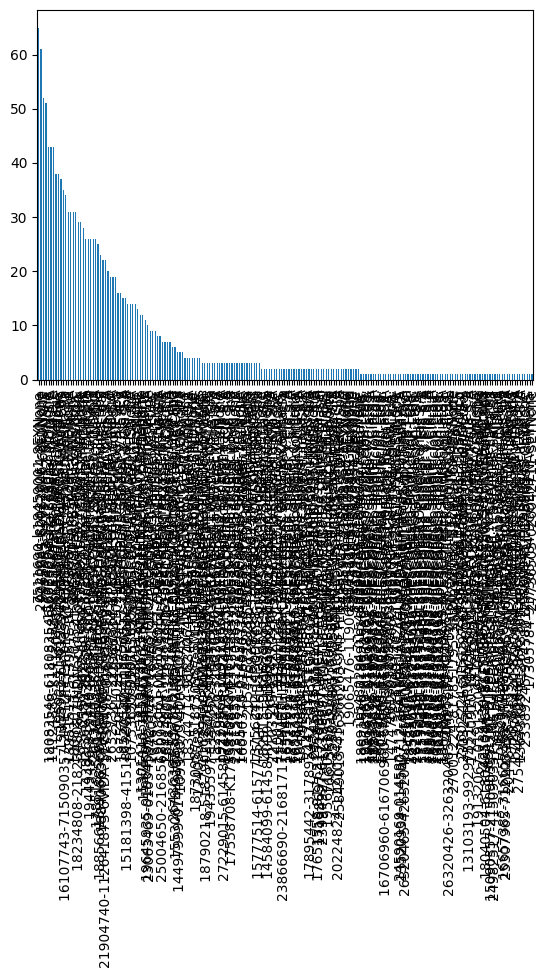

In [54]:
data30['LLave'].value_counts().plot(kind='bar')